# 1. Get Data

In [1]:
import torch
import torch.nn
import torchvision
import torchvision.transforms as transforms

In [2]:
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo. Downloading...")
  !pip -q install torchinfo
  from torchinfo import summary

try:
  from going_modular.going_modular import data_setup, engine
except:
  print("[INFO] Couldn't find going_modular.going_modular. Downloading...")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo. Downloading...
[INFO] Couldn't find going_modular.going_modular. Downloading...
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 4393 (delta 1458), reused 1399 (delta 1399), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 33.45 MiB/s, done.
Resolving deltas: 100% (2660/2660), done.
Updating files: 100% (248/248), done.


In [3]:
def download_data(source, destination, remove_source : bool = True):
  import requests
  import pathlib
  import zipfile
  import os

  data_path = pathlib.Path("data/")
  image_path = data_path / destination

  if image_path.is_dir():
    print(f"[INFO] {image_path} directory exists, skipping download.")
  else:
    print(f"[INFO] Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents = True, exist_ok = True)

    target_file = pathlib.Path(source).name
    with open(data_path / target_file, "wb") as f:
      request = requests.get(source)
      f.write(request.content)

    with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
      print(f"[INFO] Unzipping {target_file} data...")
      zip_ref.extractall(image_path)

    if remove_source:
            os.remove(data_path / target_file)

  return image_path

In [4]:
image_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
             destination = "pizza_steak_sushi")

image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

# 2. Create Datasets and DataLoaders

In [6]:
IMG_SIZE = 224
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
import os
def create_dataLoader(train_dir,
                      test_dir,
                      transforms,
                      batch_size,
                      num_workers : int = os.cpu_count()):

  train_data = torchvision.datasets.ImageFolder(train_dir, transforms)
  test_data = torchvision.datasets.ImageFolder(test_dir, transforms)
  classes = train_data.classes
  train_dataLoader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)
  test_dataLoader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False, num_workers = num_workers, pin_memory = True)
  return train_dataLoader, test_dataLoader, classes

In [8]:
train_dataLoader, test_dataLoader, classes = create_dataLoader(train_dir = train_dir,
                                                              test_dir = test_dir,
                                                              transforms = manual_transforms,
                                                              batch_size = 32)
train_dataLoader, test_dataLoader, classes

(<torch.utils.data.dataloader.DataLoader at 0x7bac33696710>,
 ['pizza', 'steak', 'sushi'])

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

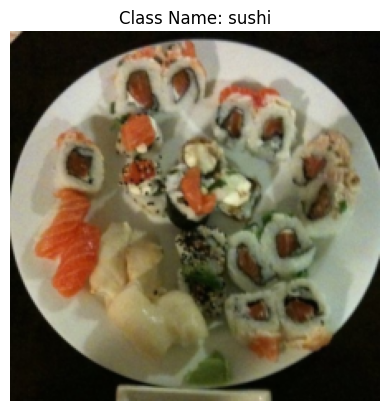

In [9]:
import matplotlib.pyplot as plt
images, labels = next(iter(train_dataLoader))
image, label = images[0], labels[0]
image.shape
plt.imshow(image.permute(1,2,0))
plt.title(f"Class Name: {classes[label]}")
plt.axis(False)

# 3. Replicating the ViT paper

#### Equation 1 overview
(1) x_input = [class_token + image_patch_1, image_patch_2, ..., image_path_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ..., image_path_poss_N]

#### Equation 2 overview

(2) x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

#### Equation 3 overview

(3) x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block

#### Equation 4 overview

Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4). Both during pre-training time and fine-tuning, a classification head is attached to $\mathbf{z}_{L}^{0}$. The classification head is implenemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

MLP -> multilayer perceptron = a neural network with X number of layers
MLP -> one hidden layer at training time
MLP -> single linear layer at fine-tuning time

(4) y = Linear_Layer(LN_layer(x_output_MLP_block[0]))



* Layers          -> the number of transformer encoder layers
* Hidden Size $D$ -> the embedding size throughout the architecture
* MLP Size        -> the number of hidden units/neurons in the MLP
* Head            -> the number of multi-head self-attention



$D$ is the size of the patch embeddings, different values for $D$ for various sized ViT models can be found in Table 1.

The image starts as 2D with size ${H \times W \times C}$.

$(H, W)$ is the resolution of the original image (height, width).

$C$ is the number of channels.

The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

$(P, P)$ is the resolution of each image patch (patch size).

$N=H W / P^{2}$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.

## Split data into patches and creating the class, position and patch embedding

Layers = input -> function -> output

* Input Shape : (224, 224, 3) -> single image -> (height, width, color channels)
* Output Shape :
**Equation 1**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N = HW/P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size D through all of its layers, so we flatten the patches and map to D dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

> **Equation 1**

Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$ position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input Shape: $H\times{W}\times{C}$ (height X width X color_channels)
* Output Shape: ${N \times\left(P^{2} \cdot C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height * width) / p^2
* D = constant latent vector size = embedding dimension (see Table 1)

In [10]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int(height * width / patch_size ** 2)
number_of_patches

196

In [11]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

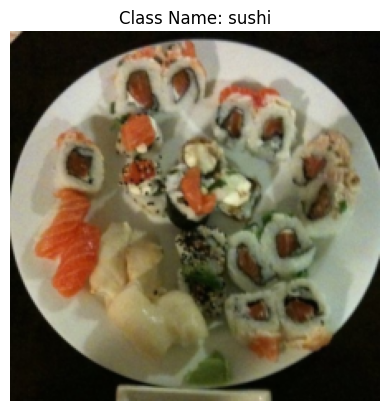

In [12]:
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Class Name: {classes[label]}")
plt.axis(False)

In [13]:
image.shape

torch.Size([3, 224, 224])

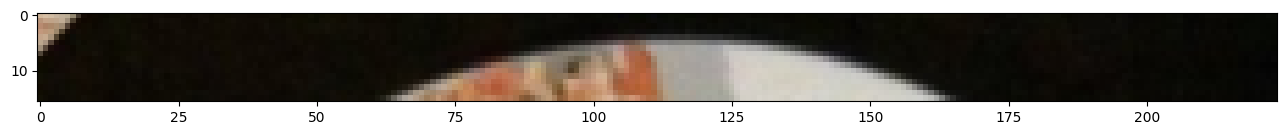

In [14]:
permuted_image = image.permute(1, 2, 0) # permuted_image.shape (224, 224, 3)
patch_size = 16
# get the top row of image
plt.figure(figsize = (patch_size, patch_size))
plt.imshow(permuted_image[ : patch_size, :, :]) # [height, width, color_channels]

Number of patches per row: 14
Patch Size: 16 pixels x 16 pixels


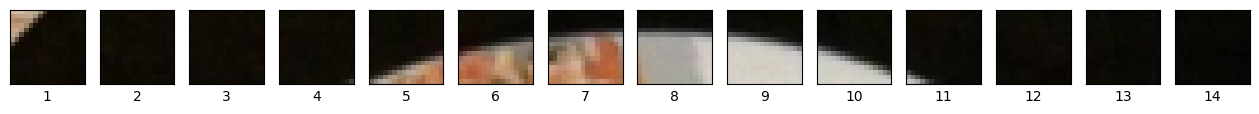

In [15]:
img_size = 224
patch_size = 16
num_patches = img_size // patch_size
print(f"Number of patches per row: {num_patches}\nPatch Size: {patch_size} pixels x {patch_size} pixels")
permuted_image = image.permute(1, 2, 0)

fig, axes = plt.subplots(nrows = 1,
                         ncols = num_patches,
                         sharex = True,
                         sharey = True,
                         figsize = (patch_size, patch_size))

for i, patch in enumerate(range(0, img_size, patch_size)):
  axes[i].imshow(permuted_image[:patch_size, patch:patch_size+patch, :])
  axes[i].set_xlabel(i+1)
  axes[i].set_xticks([])
  axes[i].set_yticks([])

Text(0.5, 0.98, 'sushi')

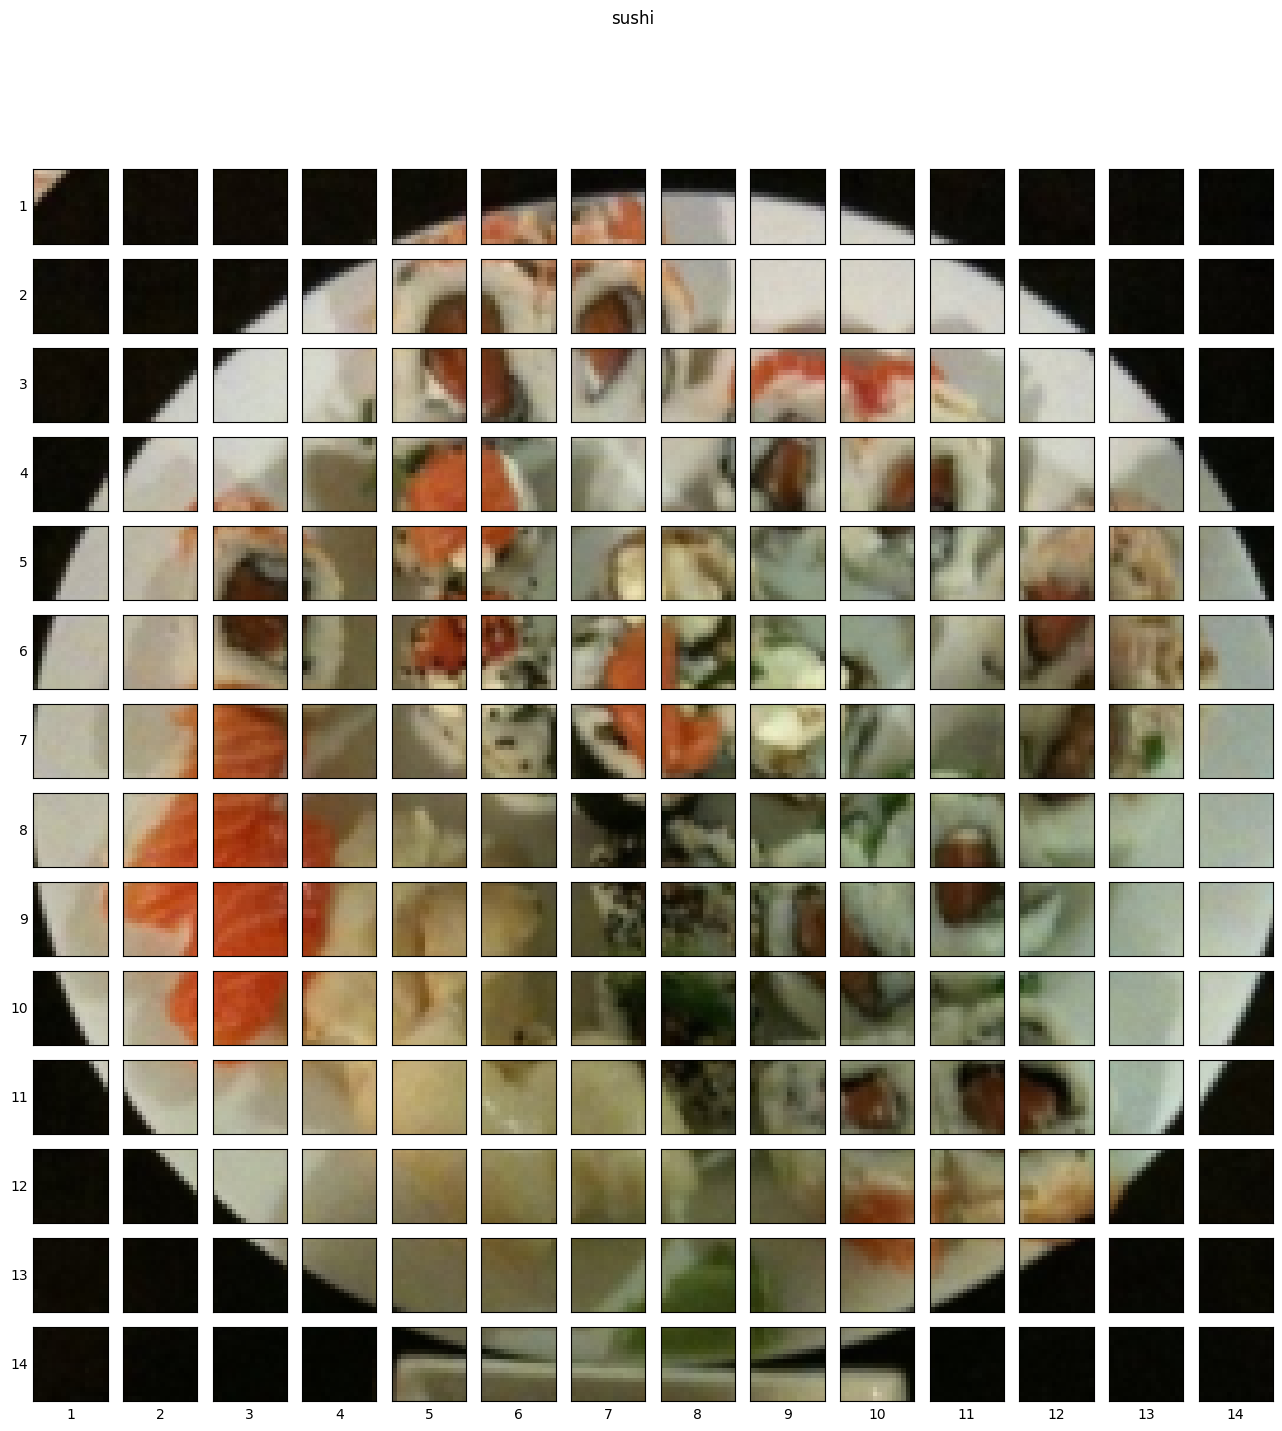

In [23]:
img_size = 224
patch_size = 16
num_patches = img_size // patch_size
permuted_image = image.permute(1, 2, 0)

fig, axes = plt.subplots(nrows = num_patches,
                         ncols = num_patches,
                         sharex = True,
                         sharey = True,
                         figsize = (patch_size, patch_size))

for i, x_patch in enumerate(range(0, img_size, patch_size)):
  for j, y_patch in enumerate(range(0, img_size, patch_size)):
    axes[i, j].imshow(permuted_image[x_patch:patch_size+x_patch, y_patch:patch_size+y_patch, :])
    axes[i, j].set_ylabel(i+1, rotation="horizontal", horizontalalignment="right", verticalalignment="center")
    axes[i, j].set_xlabel(j+1)
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])
    axes[i, j].label_outer()
fig.suptitle(classes[label])